# Using GA to Tune The LQR Drone

In [1]:
from deap import algorithms, base, benchmarks, creator, tools
from deap.benchmarks.tools import diversity, convergence, hypervolume
import array, random, json

In [2]:
%matplotlib notebook
from notebook_quick_setup import *

Beginning notebook setup...
	Added /home/jhewers/Documents/projects/jdrones/src to path
	Imported gymnasium version 0.27.1
	Imported jdrones version unknown


pybullet build time: Feb  2 2023 13:13:41


	Imported scipy==1.7.3, numpy==1.22.4, pandas==1.3.5
	Imported functools, collections and itertools
	Imported tqdm (standard and trange)
	Imported seaborn==0.11.2, matplotlib==3.5.1
End of notebook setup


In [3]:
def J(df):
    df_sums = (
        df.sort_values("t")
        .groupby(df.variable)
        .apply(lambda r: np.trapz(r.value.abs(), x=r.t))
    )
    
    df_sums[['P0','P1','P2','P3']] =0
    df_sums[['qw','qx','qy','qz']] =0
    df_sums[['x','y','z']] *= 200
    df_sums[['phi','theta']] *= 10
    df_sums['psi'] *= 50
    
    return df_sums.sum()

In [4]:
def simulate(env, u, progress=False):
    dq = collections.deque()
    obs, _ = env.reset()
    
    if progress:
        it = tqdm(u)
    else:
        it = u
    
    for ui in it:
        if np.any(np.isnan(obs)):
            obs[np.isnan(obs)] = np.inf
            dq.append(np.copy(obs))
            break
        
        dq.append(np.copy(obs))
        obs, *_ = env.step(np.concatenate([ui,np.zeros(17)]))
              
    return States(dq)

In [5]:
def get_drone(Q,R, dt):
    initial_state = State()
    initial_state.pos = (10,-10,10)
    initial_state.rpy = (0,0,1)
    initial_state.prop_omega = np.ones(4)*6
    return gymnasium.make("LQRDroneEnv-v0", Q=Q,R=R, dt=dt, initial_state=initial_state)

In [6]:
def individual_to_Q_R(individual):
    return np.diag(individual[:12]), np.diag(individual[12:])

In [7]:
def cost(individual, dt, u,  progress=False):
    Q,R = individual_to_Q_R(individual)
    
    # Check if matrix is singular
    if any(~np.isfinite(np.linalg.cond(f)) for f in (Q,R)):
        return 1e9
    try:
        env = get_drone(Q,R, dt)
    except scipy.linalg.LinAlgError:
        return 1e9
    obs = simulate(env, u, progress=progress)
    return J(obs.to_df(tag="LQR", dt=dt, N=5*T))

In [8]:
T = 15
dt = 1/50
u = np.zeros((int(T/dt),3))
CXPB, MUTPB = 0.55, 0.05

In [9]:
Q = np.array([10, 10, 1, 1, 1, 1, 100, 100, 10, 1, 1, 1]) * 1e-6
R = np.array([10, 10, 100, 0.001])
benchmark = cost(np.concatenate([Q,R]), dt, u)
benchmark

66194.27216696147

## GA

In [10]:
creator.create("FitnessMin", base.Fitness, weights=(-1,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [11]:
toolbox = base.Toolbox()

In [12]:
BOUND_LOW = np.array((1e-6,) * 12 + (1,) * 3 + (0,))
BOUND_HIGH = np.array((1e-4,) * 12 + (100,) * 3 + (1e-3,))
SCALE=np.array((1e-5,)*12+(1,)*4)
NDIM = 16

In [13]:
def mutNGaus(indiviudal,scale, N, indpb):
    p = indpb * np.ones(len(indiviudal))
    inds = np.random.choice(np.arange(0,len(indiviudal)),p=p/p.sum(),size=N)

    for i in inds:
        indiviudal[i] = np.clip(indiviudal[i] + np.random.normal(scale=scale[i]),0,np.inf)
    
    return indiviudal

In [14]:
toolbox.register("attr_float", np.random.uniform, BOUND_LOW, BOUND_HIGH, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [15]:
toolbox.register("evaluate", cost,dt=dt,u=u)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", mutNGaus, scale=SCALE,N=1, indpb=1/NDIM)
toolbox.register("select", tools.selTournament, tournsize=3)

In [16]:
def get_pop(n=30):
    pop = toolbox.population(n=n)
    # Seed with one that we know is good
    pop[0] = creator.Individual([
        8.991192078204383e-05,
        8.806431753269343e-05,
        8.091799938753304e-05,
        3.632257365747144e-05,
        6.764156497790077e-06,
        2.328062112946342e-05,
        3.28709705868307e-05,
        3.238878003477344e-05,
        4.672184058816576e-05,
        8.04579280110124e-05,
        7.189365004554992e-05,
        8.188944953864152e-05,
        2.094619920797816,
        4.1435633102757645,
        42.47949524890384,
        4.854927340822368e-05,
    ])
    return pop

In [17]:
def get_stats():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    return stats

In [18]:
def get_logbook(stats):
    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields
    return logbook

In [19]:
def get_hof(n=5):
     return tools.HallOfFame(n)

In [20]:
stats = get_stats()
pop = get_pop()

if 'logbook' not in globals():
    logbook = get_logbook(stats)
    start_gen = 0
else:
    start_gen = max(logbook, key= lambda v: v['gen'])['gen']+1
    print(f"Old logbook and population found, starting from {start_gen}")
          
if 'hof' in globals():
    for i,ind in enumerate(hof):
        pop[i] = ind
else:
    hof = get_hof()
    
for ind, fit in zip(pop, map(toolbox.evaluate, pop)):
    ind.fitness.values = (fit,)
fits = [ind.fitness.values[0] for ind in pop]
    
progress = trange(start_gen,300+start_gen)
for i in progress:
    hof.update(pop)
    
    compiled = stats.compile(pop)
    logbook.record(gen=i, evals=len(pop), **compiled)    
    progress.set_description(f"({i}) Rel. imp. = {benchmark-hof[0].fitness.values[0]:.2f} | Best: {hof[0].fitness.values[0]:.2f} | Avg: {compiled['avg']:.2f} | Std: {compiled['std']:.2f}")
  
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = (fit,)
    pop[:] = offspring
    
    fits = [ind.fitness.values[0] for ind in pop]

  0%|          | 0/300 [00:00<?, ?it/s]

In [21]:
stats = pd.DataFrame(logbook)
stats.set_index("gen", inplace=True)

<IPython.core.display.Javascript object>


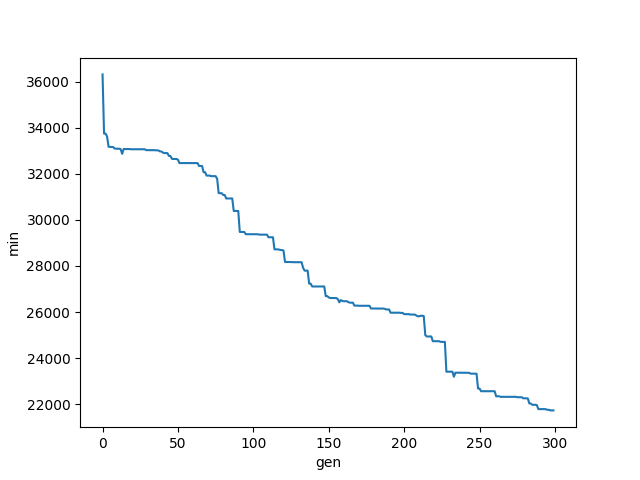

In [22]:
sns.lineplot(data=stats,x='gen',y='min')
plt.show()

In [23]:
toolbox.individual()

[7.062067209903218e-06,
 6.576833533647639e-05,
 7.084369623415247e-05,
 1.2552207854862709e-05,
 5.3136644781720035e-05,
 3.175871572844052e-05,
 3.7096635877530323e-05,
 9.967444034288037e-05,
 1.9696979627642453e-05,
 5.6001826547604396e-05,
 5.6945225490774284e-05,
 8.949332801209687e-05,
 43.214923467290554,
 5.381546150834441,
 32.89777554699542,
 0.00010392940505041349]

In [30]:
df = pd.concat(
    [
        simulate(
            get_drone(*individual_to_Q_R(f), dt),
            np.concatenate(
                [
                   np.zeros((int(30 / dt), 3))
                ]
            ),
        ).to_df(tag=t, dt=dt)
        for t, f in [["1st GA", hof[0]], ["Hand Tuned", np.concatenate([Q,R])], ["Random", toolbox.individual()]]
    ]
).reset_index()

<IPython.core.display.Javascript object>


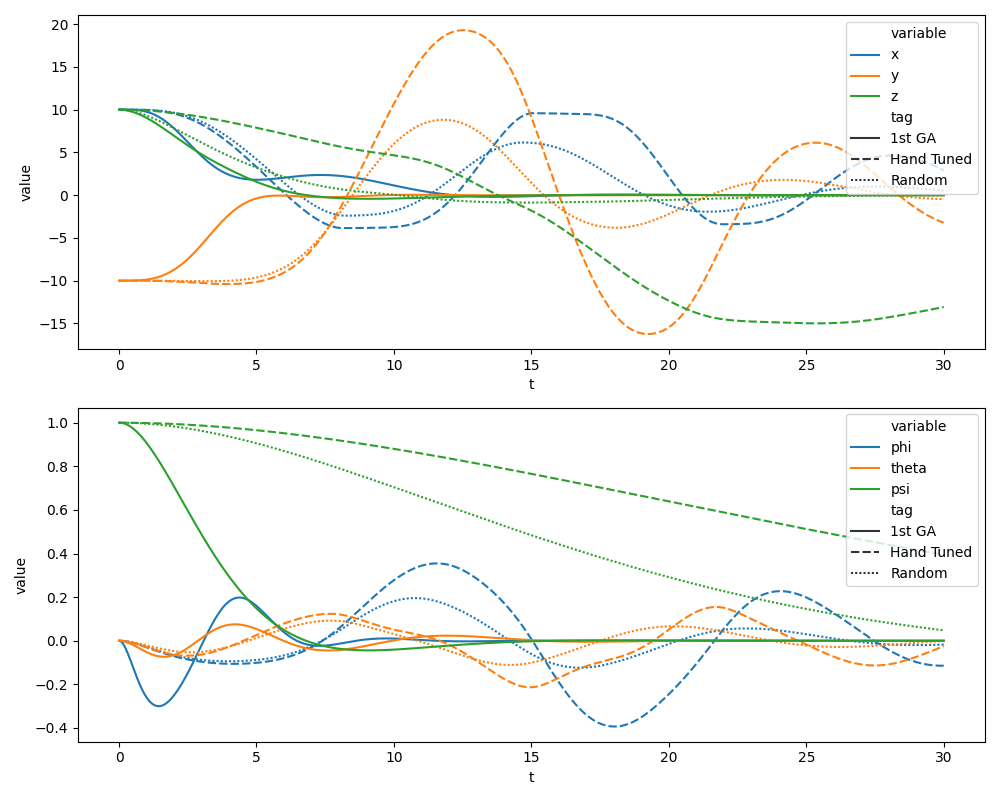

In [31]:
fig, ax = plt.subplots(2, figsize=(10, 8))
ax = ax.flatten()
for i, vars in enumerate(
    ["'x','y','z'", "'phi','theta','psi'"]
):
    sns.lineplot(
        data=df.query(f"variable in ({vars})"),
        x="t",
        y="value",
        hue="variable",
        style="tag",
        ax=ax[i],
    )
    ax[i].legend()
fig.tight_layout()
plt.show()